![title](images/menu_resultados.png)

# Resultados

Esta etapa apresentará os **resultados obtidos** a partir das **análises dos sentimentos de *tweets*** realizados no passo anterior deste trabalho.

Primeiramente, serão carregados os ***tweets* brasileiros** contendo os resultados dos ***scores***, calculados pela ferramenta VADER (1). Estes resultados, então, são agrupados por cidades.

Para cada cidade, ocorrerá a **geração dos dados** que servirão de insumos para apresentação dos resultados. Os dados serão gerados divididos em 3 períodos: **antes do primeiro caso de Covid-19 no Brasil**, **após o primeiro caso de Covid-19 no Brasil** e **após a primeira morte por Covid-19 no Brasil**. Foi estabelecida a quantidade mínima de 100 *tweets* por período, sendo selecionadas o total de 38 cidades para a análise.

Finalmente, na seção de resultados, serão apresentados gráficos com quantitativos de registros e agrupamento de **entidades** (3) que **estavam presentes nas frases que influenciaram negativamente e positivamente** os resultados dos *scores* obtidos. Estas entidades foram processadas com a utilização de um modelo de Processamento de Linguagem Natural (PNL) refinado para o tema deste trabalho.

Os resultados tem por finalidade observar o **comportamento dos usuários do Twitter** durante os períodos analisados e a que eles **podem estar relacionados**.


PARA FAZER:

Incluir no fluxo do trabalho a etapa de refinamento do modelo de PNL

**Importações gerais**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import re
import numpy as np
import collections

from wordcloud import WordCloud, STOPWORDS
from statistics import mean

import warnings
warnings.filterwarnings('ignore')

**Configurações Iniciais**

In [2]:
# Criando estrutura do banco de dados
from pymongo import MongoClient

# Conexão com o servidor do MongoDB
client = MongoClient('localhost', 27017)

# Conexão com a base de dados do mongoDB
db = client.SpedDB

# Coleção onde serão inseridos os dados
collection = db.tweets_brasil

Nas células abaixo são definidas variáveis utilizadas no procedimento de análises de resultados.

A variável referente às *hashtags* armazena *strings* a serem desconsideradas no processamento de entidades presentes nos textos dos *tweets* por serem palavras comuns ao universo dos registros presentes na base de dados (*hashtags* utilizadas pelo GeoCoV19 para a coleta de *tweets*).

In [3]:
# Hashtags que serão desconsideradas nos items de processamentos de entidades pois são hashtags base que foram utilizados pelo GeoCov19 para seleção de todos os tweets (se repetem em todos os tweets)
default_hashtags = ['coronavírus','covid19','covid2019','covid19brasil','covid2019brasil','covid','corona','coronavirusbrasil', 'coronavirusnobrasil', 'coronavirus', 'covid-19', 'covidー19', 'covid_19', 'novocoronavírus', 'coronavíru','coronaviru','víru','viru','corona','coronavírus','coronavirus','covid','covid19','covid-19','19','corona virus','corona vírus','covid 19','coronavairus','covid 2019','brasil','vírus']

# Cores
back_color_default = 'white'
back_color_dados_neg = 'indianred'
back_color_dados_pos = 'steelblue'
back_color_dados_default = 'slategrey'

# Formato de Data
date_format = '%Y-%m-%d'

## Carregamento de registros de tweets

Nos itens a seguir, é realizado o **carregamento dos registros com sentimentos processados** pelo VADER. Estes dados são carregados em um *dataframe*.

In [4]:
df = pd.DataFrame.from_records(collection.find({'lang': 'pt', 'score': {'$ne':None}, 'geo_source':{'$ne':'tweet_text'}}, {'state':1,'city':1,'lang':1,'geo_source':1,'score':1,'created_at':1,'text':1,'_id': 0}).sort('created_at'))

In [5]:
df.head()

,created_at,geo_source,state,city,text,score,lang
0,2020-02-02 09:32:32,user_location,Piauí,Amarante,RT @FuturasPromess: RTT ou amanhã acordas com ...,-0.3400,pt
1,2020-02-02 09:33:28,user_location,São Paulo,Sorocaba,RT @revistasuper: #SuperLidas A doença surgiu ...,0.0000,pt
2,2020-02-02 09:34:20,user_location,Piauí,Amarante,RT @FuturasPromess: RTT ou amanhã acordas com ...,-0.3400,pt
3,2020-02-02 09:38:24,user_location,Paraíba,João Pessoa,RT @lelispatricia: Olavo de Carvalho é o “guru...,-0.4767,pt
4,2020-02-02 09:39:50,user_location,São Paulo,Conchas,RT @da_goiabeira: Passam a vida criticando a c...,-0.3612,pt


**Quantidade total de tweets carregados**

In [6]:
len(df)

1219482

**Quantidade de *tweets* por estado**

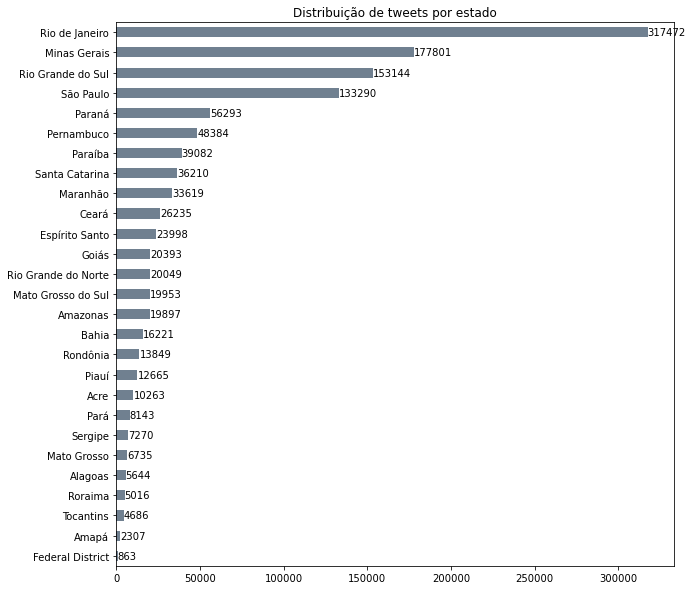

In [7]:
# Distribuição de tweets por estado
df.state.value_counts().sort_values().plot(kind='barh', figsize=(10, 10), title='Distribuição de tweets por estado', color=back_color_dados_default)

for index, value in enumerate(df.state.value_counts().sort_values()):
    plt.text(value, index, str(value), verticalalignment='center')

**Quantidade de *tweets* por cidade**

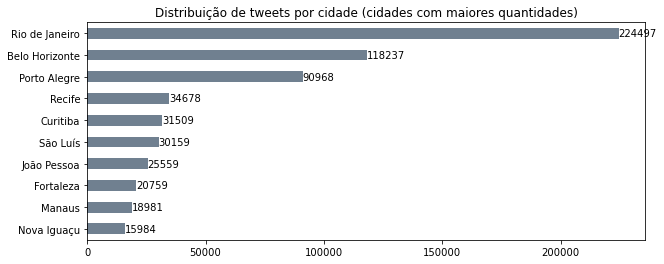

In [8]:
df_city = df.city.value_counts()[:10]

df_city.sort_values().plot(kind='barh', figsize=(10, 4), title='Distribuição de tweets por cidade (cidades com maiores quantidades)', color=back_color_dados_default)

for index, value in enumerate(df_city.sort_values()):
    plt.text(value, index, str(value), verticalalignment='center')

## Criação do conjunto de cidades

In [9]:
def create_df_cities(df):

    df_grouped = df.groupby(['city','state'])

    cities = []
    
    for item in df_grouped['city','state']:

        index = item[0]
        city = index[0]
        state = index[1]
        
        data = [city, state]
        cities.append(data)
        
        df_cities = pd.DataFrame.from_dict(cities)
        df_cities.columns = ['city', 'state']
        
        df_cities = df_cities.reset_index()
        df_cities = df_cities.drop(columns=['index'])
        
    return df_cities

In [10]:
df_cities = create_df_cities(df)

In [11]:
df_cities.head()

,city,state
0,3 Lagoas,Mato Grosso do Sul
1,Abadia dos Dourados,Minas Gerais
2,Abadiânia,Goiás
3,Abaetetuba,Pará
4,Abaeté,Minas Gerais


**Adicionando coluna city + state**

Tratamento realizado para se distinguir cidades homônimas

In [12]:
states = {
    'Acre':'AC',
    'Alagoas':'AL',
    'Amapá':'AP',
    'Amazonas':'AM',
    'Bahia':'BA',
    'Ceará':'CE',
    'Federal District':'DF',
    'Espírito Santo':'ES',
    'Goiás':'GO',
    'Maranhão':'MA',
    'Mato Grosso':'MT',
    'Mato Grosso do Sul':'MS',
    'Minas Gerais':'MG',
    'Pará':'PA',
    'Paraíba':'PB',
    'Paraná':'PR',
    'Pernambuco':'PE',
    'Piauí':'PI',
    'Rio de Janeiro':'RJ',
    'Rio Grande do Norte':'RN',
    'Rio Grande do Sul':'RS',
    'Rondônia':'RO',
    'Roraima':'RR',
    'Santa Catarina':'SC',
    'São Paulo':'SP',
    'Sergipe':'SE',
    'Tocantins':'TO',
}

In [13]:
def return_new_city_name(city, state):
    return city + " (" + states.get(state) +")"

In [14]:
df_cities['city_state'] = df_cities.apply(lambda x: return_new_city_name(x['city'],x['state']), axis=1)

In [15]:
df_cities.head()

,city,state,city_state
0,3 Lagoas,Mato Grosso do Sul,3 Lagoas (MS)
1,Abadia dos Dourados,Minas Gerais,Abadia dos Dourados (MG)
2,Abadiânia,Goiás,Abadiânia (GO)
3,Abaetetuba,Pará,Abaetetuba (PA)
4,Abaeté,Minas Gerais,Abaeté (MG)


**Quantidade de cidades carregadas**

In [16]:
len(df_cities)

2891

## Geração de dados por períodos

Nesta seção ocorre a geração de dados para os períodos analisados, detalhados a seguir:

- **Primeiro Período**: Iniciando em 01/02/2020 (data do primeiro registro da base de dados) à data anterior ao primeiro caso de Covid-19 no Brasil;
- **Segundo Período**: Iniciando na data do primeiro caso de Covid-19 na Brasil (26/02/2020) (2) à data anterior à primeira morte por Covid-19;
- **Terceiro Período**: Iniciando na data da primeira morte por Covid-19 no Brasil (12/03/2020) (7) à data do último registro da base de dados (01/05/2020).

Para cada um desses períodos, são gerados os seguintes dados que servirão de insumos para os resultados apresentados adiante:

- **Média de *score* de sentimento total**;
- **Média de *score* de sentimento por período**;
- **Quantidade total de *tweets***;
- **Quantidade total de *tweets* por período**;
- **100 entidades com maior ocorrência em frases que mais influenciaram negativamente os *scores* de sentimentos**;
- **100 entidades com maior ocorrência em frases que mais influenciaram positivamente os *scores* de sentimentos**;

As entidades são geradas com a utilização de um modelo de Processamento de Linguagem Natural (PNL), refinado para o tema tratado neste trabalho, a partir do modelo *pt_core_news_sm* do Spacy (6).

São consideradas cidades que possuam no mínimo a quantidade de 100 *tweets* por período. Esta seleção ajuda a minimizar o impacto no cálculo da média de sentimentos para períodos com poucas quantidade de *tweets*.

In [17]:
# Quantidade mínima de tweets aceitáveis para cada período
# min_tweets = 100

# Quantidade máxima de tokens a serem retornadas para cada período analisado
max_tokens = 100

# Data do primeiro caso de Covid-19 no Brasil
first_case = datetime.date(2020, 2, 26)

# Data da primeira morte de Covid-19 no Brasil
first_death = datetime.date(2020, 3, 12)

Importando o modelo de PNL refinado para este trabalho.

In [18]:
import spacy
nlp = spacy.load("/home/mario/Documentos/LCDIA/Analytics/Backup-Notebooks/tests/ner_test")

import demoji
demoji.download_codes()

... OK (Got response in 0.78 seconds)
Writing emoji data to /home/mario/.demoji/codes.json ...
... OK


Função para geração de dados por período para cada cidade:

**Geração de *tokens***

Função para retorno de entidades:

In [19]:
def generate_tweets_entities(texts):

    tokens = []
    invalid_tokens = {'rt','…','#','’','“','','``','...','\'\'','|','⠀','_','rtt','pq','rs','ai','b','c','q','vc','n','s','to','se','cére'}
          
    tokens = []
    for text in texts:
        text = demoji.replace(text,'')
        spacy_res = nlp(text.lower())
        for ent in spacy_res.ents:
            if (ent.text not in default_hashtags and ent.text not in invalid_tokens and 'http' not in ent.text):
                if (ent.ent_id_ != ''):
                    word = ent.ent_id_                   
                else:
                    word = ent.text
                tokens.append(word)
                   
    return tokens

Funções para retornar *tweets* a partir de um dado intervalo de *score*:

In [20]:
def return_most_negative_entities(df, end, max_tokens):
    
    top_words = []    
    df_query = df.loc[df['score'] < end]

    words = list(df_query['text'])
    tokens = generate_tweets_entities(words)
    counter = collections.Counter(tokens)
    
    return dict(counter.most_common(max_tokens))

In [21]:
def return_most_positive_entities(df, start, max_tokens):
    
    top_words = []    
    df_query = df.loc[df['score'] > start]

    words = list(df_query['text'])
    tokens = generate_tweets_entities(words)
    counter = collections.Counter(tokens)
    
    return dict(counter.most_common(max_tokens))

In [24]:
def calcular_qtd_tweets(df, df_cities):

    qtd_tweets = []
    qtd_tweets_1 = []
    qtd_tweets_2 = []
    qtd_tweets_3 = []
    
    total_processed = 0
    
    first_case_str = first_case.strftime('%Y-%m-%d %H:%M:%S')
    first_death_str = first_death.strftime('%Y-%m-%d %H:%M:%S')

    for index, row in df_cities.iterrows():

        city = row['city']
        state = row['state']

        total_processed = total_processed + 1

        # Trocar por count
        df_tweets_1 = df.query('city == "'+city+'" and state == "'+state+'" and created_at >= "2020-02-01 00:00:00" and created_at < "'+first_case_str+' 00:00:00"')  
        df_tweets_2 = df.query('city == "'+city+'" and state == "'+state+'" and created_at >= "'+first_case_str+' 00:00:00" and created_at < "'+first_death_str+' 00:00:00"')
        df_tweets_3 = df.query('city == "'+city+'" and state == "'+state+'" and created_at >= "'+first_death_str+' 00:00:00" and created_at < "2020-05-02 00:00:00"')
        df_tweets = pd.concat([df_tweets_1, df_tweets_2, df_tweets_3])
        
        print(total_processed, city, len(df_tweets), len(df_tweets_1), len(df_tweets_2), len(df_tweets_3))
        
        if (len(df_tweets_1) > 0 and len(df_tweets_2) > 0 and len(df_tweets_3) > 0):
            
            qtd_tweets.append(len(df_tweets))
            qtd_tweets_1.append(len(df_tweets_1))
            qtd_tweets_2.append(len(df_tweets_2))
            qtd_tweets_3.append(len(df_tweets_3))
            
        else:
            df_cities = df_cities.drop(index)

    df_cities['qtd_tweets'] = qtd_tweets
    df_cities['qtd_tweets_1'] = qtd_tweets_1
    df_cities['qtd_tweets_2'] = qtd_tweets_2
    df_cities['qtd_tweets_3'] = qtd_tweets_3
    
    return df_cities.reset_index(drop=True)

In [25]:
df_cities = calcular_qtd_tweets(df, df_cities)

1 3 Lagoas 1871 38 170 1663
2 Abadia dos Dourados 1 0 1 0
3 Abadiânia 1 0 0 1
4 Abaetetuba 43 0 4 39
5 Abaeté 1 0 0 1
6 Abaiara 2 1 0 1
7 Abaré 6 0 0 6
8 Abatiá 1 0 0 1
9 Abaíra 1 0 0 1
10 Abdon Batista 4 0 0 4
11 Abelardo Luz 12 0 0 12
12 Abre Campo 18 0 0 18
13 Abreu e Lima 10 0 0 10
14 Acaiaca 1 0 0 1
15 Acajutiba 2 0 0 2
16 Acarape 1 0 0 1
17 Acaraú 26 0 1 25
18 Acará 17 0 0 17
19 Acauã 1 0 0 1
20 Aceguá 1 0 0 1
21 Acopiara 6 0 1 5
22 Acrelândia 2 0 0 2
23 Acreúna 2 0 0 2
24 Adamantina 148 2 14 132
25 Adolfo 5 0 0 5
26 Adrianópolis 1 0 0 1
27 Adustina 2 0 0 2
28 Afogados da Ingazeira 11 0 0 11
29 Afonso Cláudio 89 1 10 78
30 Afuá 1 0 0 1
31 Agrolândia 5 0 0 5
32 Agronômica 1 0 0 1
33 Agua Branca 45 0 2 43
34 Aguaí 28 0 4 24
35 Agudo 5 0 0 5
36 Agudos 56 4 0 52
37 Aguiar 12 0 1 11
38 Aimorés 21 0 4 17
39 Aiuruoca 7 0 0 7
40 Ajuricaba 5 0 1 4
41 Alagoa 1 0 1 0
42 Alagoa Grande 45 2 2 41
43 Alagoa Nova 11 0 0 11
44 Alagoinha 118 1 9 108
45 Alagoinhas 267 1 7 259
46 Alambari 7 0 0 7
47

340 Birigui 207 7 17 183
341 Biritiba-Mirim 1 0 0 1
342 Biritinga 3 0 0 3
343 Bituruna 9 0 1 8
344 Blumenau 3103 54 200 2849
345 Boa Esperança 299 6 22 271
346 Boa Ventura 3 0 0 3
347 Boa Ventura de São Roque 1 0 0 1
348 Boa Viagem 845 16 41 788
349 Boa Vista 4829 106 412 4311
350 Boa Vista da Aparecida 1 0 0 1
351 Boa Vista do Buricá 3 0 0 3
352 Bocaina 9 0 0 9
353 Bocaina de Minas 3 1 0 2
354 Bocaiuva 302 2 7 293
355 Bodocó 2 0 0 2
356 Bofete 3 0 0 3
357 Boituva 44 1 5 38
358 Bom Despacho 177 1 12 164
359 Bom Jardim de Goiás 1 0 0 1
360 Bom Jardim de Minas 6 0 1 5
361 Bom Jesus 1424 38 115 1271
362 Bom Jesus da Lapa 5 0 0 5
363 Bom Jesus de Goiás 4 0 0 4
364 Bom Jesus do Amparo 1 0 0 1
365 Bom Jesus do Galho 1 0 0 1
366 Bom Jesus do Itabapoana 12 0 1 11
367 Bom Jesus do Norte 12 0 0 12
368 Bom Jesus dos Perdões 4 0 0 4
369 Bom Lugar 65 0 6 59
370 Bom Retiro do Sul 1 0 0 1
371 Bom Sucesso 3 0 0 3
372 Bombinhas 48 3 4 41
373 Bonfim 106 0 9 97
374 Bonfinópolis 1 0 0 1
375 Boninal 14 0 0

668 Chaval 26 0 0 26
669 Chavantes 4 0 0 4
670 Chiador 3 0 1 2
671 Chiapetta 1 0 0 1
672 Chopinzinho 19 0 4 15
673 Chorozinho 5 0 0 5
674 Choró 1 0 0 1
675 Chuí 46 4 0 42
676 Chácara 33 1 2 30
677 Cianorte 86 3 11 72
678 Cidade Gaúcha 102 1 3 98
679 Cidade Ocidental 25 5 3 17
680 Cidreira 76 2 5 69
681 Cipotânea 7 0 0 7
682 Cipó 5 0 1 4
683 Ciríaco 12 0 0 12
684 Claraval 3 0 0 3
685 Clevelândia 5 0 0 5
686 Cláudia 26 1 2 23
687 Cláudio 37 4 3 30
688 Coaraci 4 0 1 3
689 Coari 72 0 3 69
690 Cocal 15 0 1 14
691 Cocal de Telha 1 0 0 1
692 Cocal do Sul 5 0 0 5
693 Cocalzinho de Goiás 1 0 0 1
694 Cocos 5 0 1 4
695 Codó 8 0 0 8
696 Coelho Neto 266 4 32 230
697 Colares 11 1 0 10
698 Colatina 397 6 27 364
699 Colinas 75 2 18 55
700 Colinas do Tocantins 1 0 0 1
701 Colméia 12 0 1 11
702 Colombo 65 0 4 61
703 Coluna 21 1 1 19
704 Colíder 5 0 0 5
705 Combinado 1 0 0 1
706 Comendador Levy Gasparian 7 0 0 7
707 Comodoro 6 0 0 6
708 Conceição 42 0 6 36
709 Conceição da Aparecida 3 0 0 3
710 Conceição

989 Funilândia 1 0 0 1
990 Fênix 8 0 2 6
991 Gado Bravo 19 0 1 18
992 Galiléia 2 0 0 2
993 Galvão 3 0 0 3
994 Gama 1 0 0 1
995 Gameleira 3 0 0 3
996 Gameleira de Goiás 1 0 0 1
997 Gandu 50 0 0 50
998 Garanhuns 451 7 30 414
999 Gararu 1 0 0 1
1000 Garibaldi 77 3 6 68
1001 Garopaba 192 0 11 181
1002 Garruchos 1 0 0 1
1003 Garuva 37 1 1 35
1004 Garça 157 2 3 152
1005 Gaspar 138 3 13 122
1006 Gastão Vidigal 3 0 1 2
1007 Gaurama 3 0 0 3
1008 General Sampaio 2 0 0 2
1009 Gentil 14 0 2 12
1010 Getulina 5 0 0 5
1011 Getúlio Vargas 6 0 0 6
1012 Gilbués 10 0 0 10
1013 Giruá 39 2 1 36
1014 Glorinha 14 0 1 13
1015 Glória 141 1 36 104
1016 Godofredo Viana 1 0 0 1
1017 Goiabeira 2 0 0 2
1018 Goiana 181 1 14 166
1019 Goianinha 93 0 14 79
1020 Goianira 25 0 0 25
1021 Goianá 1 0 0 1
1022 Goianápolis 10 1 2 7
1023 Goianésia 81 2 12 67
1024 Goiatins 6 0 0 6
1025 Goiatuba 39 0 2 37
1026 Goioerê 3 0 0 3
1027 Goiânia 15648 540 1235 13873
1028 Gonçalves Dias 4 0 0 4
1029 Governador Celso Ramos 6 0 1 5
1030 G

1329 Itinga 4 0 0 4
1330 Itinga do Maranhão 1 0 0 1
1331 Itiquira 1 0 0 1
1332 Itirapina 2 0 0 2
1333 Itiruçu 1 0 0 1
1334 Itiúba 48 1 8 39
1335 Itu 505 7 33 465
1336 Ituaçu 4 0 0 4
1337 Ituberá 1 0 0 1
1338 Itueta 2 0 0 2
1339 Ituiutaba 324 2 20 302
1340 Itumbiara 151 7 13 131
1341 Itumirim 3 0 0 3
1342 Itupeva 245 7 13 225
1343 Itupiranga 15 0 0 15
1344 Ituporanga 76 1 10 65
1345 Iturama 15 1 0 14
1346 Itutinga 2 0 0 2
1347 Ituverava 28 1 1 26
1348 Itá 297 2 25 270
1349 Itápolis 101 1 6 94
1350 Iuiú 1 0 0 1
1351 Ivaiporã 27 1 1 25
1352 Ivatuba 1 0 0 1
1353 Ivaí 9 0 1 8
1354 Ivinhema 5 0 0 5
1355 Ivoti 42 3 3 36
1356 Içara 71 1 3 67
1357 Iúna 67 0 5 62
1358 Jaboatão dos Guararapes 668 10 46 612
1359 Jaborandi 9 0 0 9
1360 Jaborá 3 0 0 3
1361 Jaboticaba 8 0 1 7
1362 Jaboticabal 85 3 3 79
1363 Jaboticatubas 15 0 1 14
1364 Jacaraci 2 0 0 2
1365 Jacaraú 1 0 0 1
1366 Jacareacanga 1 0 0 1
1367 Jacarezinho 95 0 4 91
1368 Jacareí 776 12 56 708
1369 Jaci 1 0 0 1
1370 Jaciara 13 1 0 12
1371 Jac

1656 Matias Olímpio 1 0 0 1
1657 Matinha 2 0 0 2
1658 Matinhos 180 3 13 164
1659 Matipó 18 0 1 17
1660 Matos Costa 2 0 0 2
1661 Matozinhos 26 1 4 21
1662 Matrinchã 1 0 0 1
1663 Matupá 11 0 3 8
1664 Matão 109 1 13 95
1665 Matões 7 0 0 7
1666 Mauriti 10 0 1 9
1667 Mauá 715 17 53 645
1668 Maués 3 0 0 3
1669 Mazagão 8 0 0 8
1670 Medeiros 3 0 0 3
1671 Medeiros Neto 13 0 1 12
1672 Medianeira 140 1 13 126
1673 Medicilândia 4 0 0 4
1674 Medina 1 0 0 1
1675 Meleiro 1 0 0 1
1676 Mendes 15 0 3 12
1677 Mendes Pimentel 2 0 0 2
1678 Mendonça 7 0 0 7
1679 Mercedes 10 0 0 10
1680 Mercês 4 1 0 3
1681 Meruoca 8 0 0 8
1682 Mesquita 2034 26 208 1800
1683 Messias 6 1 0 5
1684 Miguel Alves 2 0 0 2
1685 Miguel Calmon 18 2 2 14
1686 Miguel Pereira 537 8 53 476
1687 Miguelópolis 22 0 0 22
1688 Milagres 28 0 4 24
1689 Mimoso do Sul 9 0 0 9
1690 Minas Novas 20 1 2 17
1691 Minaçu 8 0 0 8
1692 Mineiros 94 3 13 78
1693 Mira Estrela 1 0 0 1
1694 Mirabela 5 0 0 5
1695 Miracatu 4 0 1 3
1696 Miracema 81 1 9 71
1697 Mir

1973 Paudalho 50 0 1 49
1974 Pauini 1 0 0 1
1975 Paula Cândido 10 1 1 8
1976 Paula Freitas 5 0 0 5
1977 Paulicéia 34 0 1 33
1978 Paulista 1205 18 88 1099
1979 Paulistana 215 3 16 196
1980 Paulistas 1 0 0 1
1981 Paulistânia 21 0 1 20
1982 Paulo Afonso 595 6 48 541
1983 Paulo Frontin 10 0 1 9
1984 Paulo Lopes 15 0 2 13
1985 Paulo Ramos 11 0 0 11
1986 Paulo de Faria 1 0 0 1
1987 Paulínia 299 3 24 272
1988 Paverama 6 0 1 5
1989 Paço do Lumiar 39 1 1 37
1990 Peabiru 9 0 5 4
1991 Pederneiras 22 0 1 21
1992 Pedra 107 7 21 79
1993 Pedra Azul 82 0 11 71
1994 Pedra Bela 3 0 0 3
1995 Pedra Branca 242 6 16 220
1996 Pedra Dourada 8 0 1 7
1997 Pedra Mole 61 0 0 61
1998 Pedra do Anta 5 0 0 5
1999 Pedralva 3 0 0 3
2000 Pedranópolis 1 0 0 1
2001 Pedras Altas 1 0 0 1
2002 Pedras Grandes 2 0 0 2
2003 Pedregulho 3 0 0 3
2004 Pedreira 183 2 9 172
2005 Pedreiras 9 1 1 7
2006 Pedrinhas 4 0 1 3
2007 Pedro Afonso 10 1 0 9
2008 Pedro Canário 9 0 2 7
2009 Pedro Gomes 13 1 1 11
2010 Pedro II 53 0 3 50
2011 Pedro 

2287 Rio Pomba 174 1 32 141
2288 Rio Preto 7059 129 476 6454
2289 Rio Real 23 0 1 22
2290 Rio Verde 68 0 2 66
2291 Rio das Ostras 196 3 19 174
2292 Rio de Contas 4 0 0 4
2293 Rio de Janeiro 224497 5521 18562 200414
2294 Rio do Oeste 4 0 0 4
2295 Rio do Pires 6 0 0 6
2296 Rio do Sul 54 3 3 48
2297 Riolândia 1 0 0 1
2298 Riozinho 10 0 1 9
2299 Riqueza 1 0 0 1
2300 Ritápolis 1 0 0 1
2301 Roca Sales 16 1 2 13
2302 Rochedo 57 0 17 40
2303 Rochedo de Minas 1 0 0 1
2304 Rodeio 40 1 3 36
2305 Rodeio Bonito 14 0 1 13
2306 Rodolfo Fernandes 1 0 1 0
2307 Rodrigues Alves 6 0 0 6
2308 Rolante 18 0 1 17
2309 Rolim de Moura 9 0 0 9
2310 Rolândia 67 0 4 63
2311 Romelândia 2 0 0 2
2312 Roncador 9 0 0 9
2313 Rondinha 3 0 0 3
2314 Rondolândia 6 0 0 6
2315 Rondon 1 0 0 1
2316 Rondonópolis 614 66 49 499
2317 Roque Gonzales 52 0 2 50
2318 Rorainópolis 8 0 0 8
2319 Roseira 8 0 0 8
2320 Rosário do Sul 17 0 2 15
2321 Rubiataba 7 0 1 6
2322 Rubim 3 0 0 3
2323 Rubinéia 2 0 1 1
2324 Russas 23 0 0 23
2325 Ruy Barb

2569 São José dos Campos 341 6 18 317
2570 São José dos Pinhais 244 4 18 222
2571 São José dos Quatro Marcos 1 0 0 1
2572 São João Batista 12 0 1 11
2573 São João Evangelista 3 0 0 3
2574 São João Nepomuceno 10 0 0 10
2575 São João da Barra 13 0 2 11
2576 São João da Boa Vista 19 3 1 15
2577 São João de Meriti 673 14 44 615
2578 São João del-Rei 38 0 4 34
2579 São João do Manhuaçu 1 0 0 1
2580 São João do Manteninha 2 0 0 2
2581 São João do Oeste 1 0 0 1
2582 São João do Piauí 4 1 0 3
2583 São João do Triunfo 2 0 0 2
2584 São João dos Patos 1 0 1 0
2585 São Leopoldo 2993 57 193 2743
2586 São Lourenço 1733 19 126 1588
2587 São Lourenço da Mata 35 1 2 32
2588 São Lourenço do Oeste 18 0 0 18
2589 São Lourenço do Sul 21 1 2 18
2590 São Ludgero 5 0 0 5
2591 São Luiz Gonzaga 7 0 4 3
2592 São Luís 30159 572 2480 27107
2593 São Luís de Montes Belos 5 0 0 5
2594 São Mateus 2756 62 231 2463
2595 São Mateus do Maranhão 4 0 3 1
2596 São Mateus do Sul 6 0 0 6
2597 São Miguel do Anta 2 0 0 2
2598 Sã

2877 Zacarias 2 0 0 2
2878 Zé Doca 1 0 1 0
2879 Água Boa 156 6 21 129
2880 Água Doce do Maranhão 1 0 0 1
2881 Água Fria 4 0 0 4
2882 Água Fria de Goiás 2 0 0 2
2883 Água Nova 28 0 1 27
2884 Águas Formosas 5 0 1 4
2885 Águas Lindas de Goiás 20 1 0 19
2886 Águas Mornas 1 1 0 0
2887 Águas Vermelhas 1 0 0 1
2888 Áurea 23 1 0 22
2889 Ângulo 1 0 0 1
2890 Óbidos 5 2 2 1
2891 Óleo 2 0 0 2


In [26]:
df_cities.head()

,city,state,city_state,qtd_tweets,qtd_tweets_1,qtd_tweets_2,qtd_tweets_3
0,3 Lagoas,Mato Grosso do Sul,3 Lagoas (MS),1871,38,170,1663
1,Adamantina,São Paulo,Adamantina (SP),148,2,14,132
2,Afonso Cláudio,Espírito Santo,Afonso Cláudio (ES),89,1,10,78
3,Alagoa Grande,Paraíba,Alagoa Grande (PB),45,2,2,41
4,Alagoinha,Pernambuco,Alagoinha (PE),118,1,9,108


In [27]:
len(df_cities)

890

In [28]:
df_cities.to_csv(r'df_all_cities.csv')

In [29]:
# Calcular média de tweets por período
qtd_tweets_mean = mean(df_cities['qtd_tweets'])
qtd_tweets_1_mean = mean(df_cities['qtd_tweets_1'])
qtd_tweets_2_mean = mean(df_cities['qtd_tweets_2'])
qtd_tweets_3_mean = mean(df_cities['qtd_tweets_3'])

print(qtd_tweets_mean, qtd_tweets_1_mean, qtd_tweets_2_mean, qtd_tweets_3_mean)

1341.2696629213483 30.919101123595507 112.40224719101124 1197.9483146067416


In [32]:
def generate_cities_scores_data(df, df_cities):

    score_mean = []
    score_mean_1 = []
    score_mean_2 = []
    score_mean_3 = []

    tokens_neg = []
    tokens_neg_1 = []
    tokens_neg_2 = []
    tokens_neg_3 = []

    tokens_pos = []
    tokens_pos_1 = []
    tokens_pos_2 = []
    tokens_pos_3 = []

    total_processed = 0
    
    first_case_str = first_case.strftime('%Y-%m-%d %H:%M:%S')
    first_death_str = first_death.strftime('%Y-%m-%d %H:%M:%S')

    for index, row in df_cities.iterrows():

        city = row['city']
        state = row['state']

        total_processed = total_processed + 1

        df_tweets_1 = df.query('city == "'+city+'" and state == "'+state+'" and created_at >= "2020-02-01 00:00:00" and created_at < "'+first_case_str+' 00:00:00"')  
        df_tweets_2 = df.query('city == "'+city+'" and state == "'+state+'" and created_at >= "'+first_case_str+' 00:00:00" and created_at < "'+first_death_str+' 00:00:00"')
        df_tweets_3 = df.query('city == "'+city+'" and state == "'+state+'" and created_at >= "'+first_death_str+' 00:00:00" and created_at < "2020-05-02 00:00:00"')
        df_tweets = pd.concat([df_tweets_1, df_tweets_2, df_tweets_3])

        print(total_processed, city, len(df_tweets_1), len(df_tweets_2), len(df_tweets_3))
        
        if (len(df_tweets_1) >= qtd_tweets_1_mean and len(df_tweets_2) >= qtd_tweets_2_mean and len(df_tweets_3) >= qtd_tweets_3_mean):

            # Calculando médias de scores totais e por período
            
            score_mean.append(mean(df_tweets['score']))        
            score_mean_1.append(mean(df_tweets_1['score']))
            score_mean_2.append(mean(df_tweets_2['score']))
            score_mean_3.append(mean(df_tweets_3['score']))
            
            # Gerando entidades negativas e positivas
            
            # Primeiro quartil
            end = df_tweets['score'].describe()['25%']

            # Entidades que mais influenciaram negativamente para cada período
            tokens_city_neg = return_most_negative_entities(df_tweets, end, max_tokens)
            tokens_city_neg_1 = return_most_negative_entities(df_tweets_1, end, max_tokens)
            tokens_city_neg_2 = return_most_negative_entities(df_tweets_2, end, max_tokens)
            tokens_city_neg_3 = return_most_negative_entities(df_tweets_3, end, max_tokens)

            tokens_neg.append(tokens_city_neg)
            tokens_neg_1.append(tokens_city_neg_1)
            tokens_neg_2.append(tokens_city_neg_2)
            tokens_neg_3.append(tokens_city_neg_3)

            # Último quartil
            start = df_tweets['score'].describe()['75%']

            # Entidades que mais influenciaram positivamente para cada período
            tokens_city_pos = return_most_positive_entities(df_tweets, start, max_tokens)
            tokens_city_pos_1 = return_most_positive_entities(df_tweets_1, start, max_tokens)
            tokens_city_pos_2 = return_most_positive_entities(df_tweets_2, start, max_tokens)
            tokens_city_pos_3 = return_most_positive_entities(df_tweets_3, start, max_tokens)

            tokens_pos.append(tokens_city_pos)
            tokens_pos_1.append(tokens_city_pos_1)
            tokens_pos_2.append(tokens_city_pos_2)
            tokens_pos_3.append(tokens_city_pos_3)

        else:
            df_cities = df_cities.drop(index)

    df_cities['score_mean'] = score_mean
    df_cities['score_mean_1'] = score_mean_1
    df_cities['score_mean_2'] = score_mean_2
    df_cities['score_mean_3'] = score_mean_3
    
    df_cities['tokens_neg'] = tokens_neg
    df_cities['tokens_neg_1'] = tokens_neg_1
    df_cities['tokens_neg_2'] = tokens_neg_2
    df_cities['tokens_neg_3'] = tokens_neg_3

    df_cities['tokens_pos'] = tokens_pos
    df_cities['tokens_pos_1'] = tokens_pos_1
    df_cities['tokens_pos_2'] = tokens_pos_2
    df_cities['tokens_pos_3'] = tokens_pos_3
    
    return df_cities.reset_index(drop=True)

In [33]:
df_cities = generate_cities_scores_data(df, df_cities)

1 3 Lagoas 38 170 1663
2 Adamantina 2 14 132
3 Afonso Cláudio 1 10 78
4 Alagoa Grande 2 2 41
5 Alagoinha 1 9 108
6 Alagoinhas 1 7 259
7 Alegre 40 73 1244
8 Alegrete 5 11 207
9 Alfenas 8 22 265
10 Alfredo Wagner 1 3 23
11 Alhandra 1 2 3
12 Almeirim 6 75 93
13 Almenara 1 3 15
14 Almirante Tamandaré 9 22 187
15 Alta Floresta 10 21 234
16 Altinópolis 2 8 51
17 Alto Alegre 1 1 58
18 Alto Araguaia 30 35 151
19 Alto Garças 1 2 8
20 Alto Paraguai 1 1 5
21 Alvorada 21 41 750
22 Além Paraíba 18 55 389
23 Amarante 35 484 612
24 Americana 41 140 1364
25 Ananindeua 16 66 1347
26 Andirá 1 1 10
27 Angicos 4 1 29
28 Angra dos Reis 5 21 285
29 Antonina 3 5 41
30 Anápolis 24 67 766
31 Aparecida 3 4 104
32 Aparecida de Goiânia 1 7 112
33 Apodi 2 6 89
34 Apucarana 14 16 192
35 Aquidauana 3 9 100
36 Aquiraz 15 15 210
37 Aracaju 145 395 5170
38 Aracati 2 2 37
39 Aracruz 1 19 259
40 Araguari 6 13 172
41 Araguaína 17 35 492
42 Arapiraca 10 34 512
43 Arapongas 2 8 158
44 Araquari 1 2 32
45 Araranguá 1 7 136
46

362 Ilhabela 1 11 140
363 Ilhéus 1 25 364
364 Imbituba 4 13 148
365 Imbé 4 8 148
366 Imperatriz 10 45 960
367 Indaial 6 19 196
368 Indaiatuba 7 57 555
369 Inhaúma 1 9 67
370 Inhumas 6 2 56
371 Ipanema 1 4 70
372 Ipanguaçu 1 1 26
373 Ipatinga 20 143 1510
374 Iperó 1 10 41
375 Ipojuca 3 2 52
376 Ipuã 1 4 34
377 Iranduba 4 7 42
378 Irati 2 13 141
379 Itaberá 1 5 32
380 Itabira 24 47 589
381 Itabirito 1 7 56
382 Itaboraí 13 79 524
383 Itabuna 9 20 274
384 Itacaré 4 9 52
385 Itacoatiara 1 10 103
386 Itaguaí 12 68 596
387 Itajaí 24 125 1311
388 Itajubá 4 17 592
389 Itanhaem 12 13 123
390 Itanhandu 1 3 61
391 Itaocara 1 4 28
392 Itaparica 1 1 11
393 Itapecerica 3 16 123
394 Itapema 16 39 449
395 Itapemirim 33 143 1375
396 Itaperuna 5 23 286
397 Itapetininga 7 33 306
398 Itapeva 3 17 132
399 Itapevi 5 12 112
400 Itapipoca 1 3 57
401 Itapiranga 6 8 28
402 Itapoá 1 4 153
403 Itapé 1 5 31
404 Itaquaquecetuba 8 18 186
405 Itararé 12 8 145
406 Itatiba 1 14 208
407 Itaí 3 10 113
408 Itaúna 4 26 174


719 Sabará 3 25 277
720 Salgueiro 3 19 272
721 Salto 3 2 28
722 Salvaterra 8 89 109
723 Samambaia 2 16 202
724 Sanharó 1 3 22
725 Santa Cruz Cabrália 1 3 5
726 Santa Cruz do Sul 1 2 55
727 Santa Inês 3 9 156
728 Santa Izabel do Pará 1 1 17
729 Santa Luzia 1 2 232
730 Santa Margarida 1 12 20
731 Santa Maria 285 2411 11199
732 Santa Maria de Jetibá 1 10 17
733 Santa Rita 12 42 515
734 Santa Rosa 1 5 33
735 Santana do Matos 1 5 25
736 Santarém 4 12 245
737 Santo Amaro 5 7 101
738 Santo Anastácio 2 1 63
739 Santo André 200 809 9439
740 Santo Antônio de Jesus 1 2 7
741 Santo Augusto 1 5 130
742 Santo Ângelo 15 39 559
743 Santos 120 552 5610
744 Santos Dumont 8 53 386
745 Sapezal 1 7 19
746 Sapiranga 5 17 249
747 Sapucaia do Sul 6 25 352
748 Saquarema 7 83 824
749 Sarandi 8 26 527
750 Saudades 1 3 32
751 Seberi 1 1 13
752 Segredo 2 12 30
753 Senador Canedo 2 4 117
754 Serra 13 117 861
755 Serra Branca 1 1 18
756 Serra Dourada 1 8 57
757 Serra Negra 5 8 225
758 Serra Talhada 1 25 188
759 Serr

In [34]:
df_cities.head()

,city,state,city_state,qtd_tweets,qtd_tweets_1,qtd_tweets_2,qtd_tweets_3,score_mean,score_mean_1,score_mean_2,score_mean_3,tokens_neg,tokens_neg_1,tokens_neg_2,tokens_neg_3,tokens_pos,tokens_pos_1,tokens_pos_2,tokens_pos_3
0,3 Lagoas,Mato Grosso do Sul,3 Lagoas (MS),1871,38,170,1663,-0.053688,0.067784,0.010019,-0.062976,"{'mortes': 44, 'bolsonaro': 32, 'mortos': 20, ...","{'china': 2, 'eua': 2}","{'estadunidenses': 8, 'sus': 4, 'eua': 2, 'tl'...","{'mortes': 43, 'bolsonaro': 31, 'mortos': 20, ...","{'bolsonaro': 27, 'mortes': 17, 'deus': 16, 'q...","{'rt @revistasuper: saiba': 1, 'extrema-direit...","{'são paulo': 7, 'ces': 4, 'sp?': 4, 'carnaval...","{'bolsonaro': 26, 'deus': 16, 'mortes': 16, 'q..."
1,Americana,São Paulo,Americana (SP),1545,41,140,1364,-0.034433,-0.154476,-0.070008,-0.027173,"{'bolsonaro': 52, 'mortes': 31, 'mortos': 13, ...","{'china': 3, 'mortos': 2, 'mortes': 2, 'irã': ...","{'fake news': 4, 'imprensa': 3, 'irã': 2, 'mor...","{'bolsonaro': 50, 'mortes': 27, 'quarentena': ...","{'bolsonaro': 37, 'deus': 14, 'mortes': 10, 'c...","{'wish': 1, 'bolsonaro': 1, 'wuhan': 1, 'dengu...","{'sp': 3, 'estados unidos': 2, 'the office': 2...","{'bolsonaro': 35, 'deus': 13, 'mortes': 10, 'q..."
2,Aracaju,Sergipe,Aracaju (SE),5710,145,395,5170,-0.050649,-0.072939,-0.024551,-0.052018,"{'bolsonaro': 163, 'mortes': 131, 'mortos': 80...","{'china': 8, 'mortos': 4, 'mortes': 3, 'sus': ...","{'itália': 8, 'gripe': 7, 'sus': 7, 'to tao po...","{'bolsonaro': 162, 'mortes': 128, 'mortos': 76...","{'bolsonaro': 113, 'deus': 69, 'mortes': 57, '...","{'china': 4, 'do japão': 3, 'quarentena': 2, '...","{'bolsonaro': 7, 'são paulo': 7, 'vacina': 4, ...","{'bolsonaro': 106, 'deus': 65, 'mortes': 57, '..."
3,Barra Mansa,Rio de Janeiro,Barra Mansa (RJ),1936,40,220,1676,-0.042723,0.018835,0.002376,-0.050112,"{'mortes': 29, 'sus': 21, 'bolsonaro': 19, 'mo...","{'gnt': 1, 'frança': 1, 'mortes': 1, 'europa': 1}","{'to tao podre': 3, 'sus': 2, 'barra mansa': 2...","{'mortes': 28, 'sus': 19, 'bolsonaro': 19, 'mo...","{'deus': 33, 'são paulo': 22, 'sus': 15, 'bols...","{'gringo': 1, 'crlh pro bra': 1, '_ lindinho':...","{'são paulo': 22, 'deus': 4, 'carnaval': 3, 't...","{'deus': 28, 'sus': 13, 'bolsonaro': 13, 'quar..."
4,Belford Roxo,Rio de Janeiro,Belford Roxo (RJ),3624,62,372,3190,0.004392,-0.006356,0.020367,0.002738,"{'bolsonaro': 40, 'sus': 37, 'mortes': 35, 'de...","{'carnaval': 1, 'comércio': 1, 'coronavirus!':...","{'sus': 5, 'estadunidenses': 4, 'gripe': 2, 'k...","{'bolsonaro': 40, 'mortes': 35, 'sus': 32, 'de...","{'deus': 80, 'bolsonaro': 35, 'sus': 25, 'vaci...","{'praga': 2, 'morcego': 2, 'itália': 2, 'mande...","{'to 100': 4, 'donald trump': 4, 'babu': 4, 'b...","{'deus': 80, 'bolsonaro': 32, 'sus': 25, 'quar..."


In [35]:
df_cities.to_csv(r'df_cities.csv')

**Quantidade de cidades a serem analisadas**

Total de cidades que obtiveram o número mínimo de 100 *tweets* por período analisado:

In [36]:
len(df_cities)

86

## Análise de Resultados

**Métricas estatísticas a partir da média de *scores***

In [37]:
df_cities['score_mean'].describe()

count    86.000000
mean     -0.043985
std       0.015145
min      -0.084883
25%      -0.053589
50%      -0.043879
75%      -0.034656
max       0.004392
Name: score_mean, dtype: float64

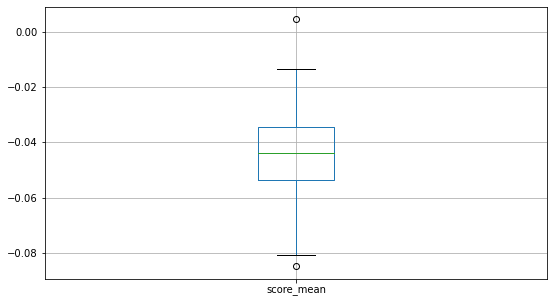

In [181]:
boxplot = df_cities.boxplot(column=['score_mean'], grid=True, figsize=(9, 5))

**Gráficos de totalizações**

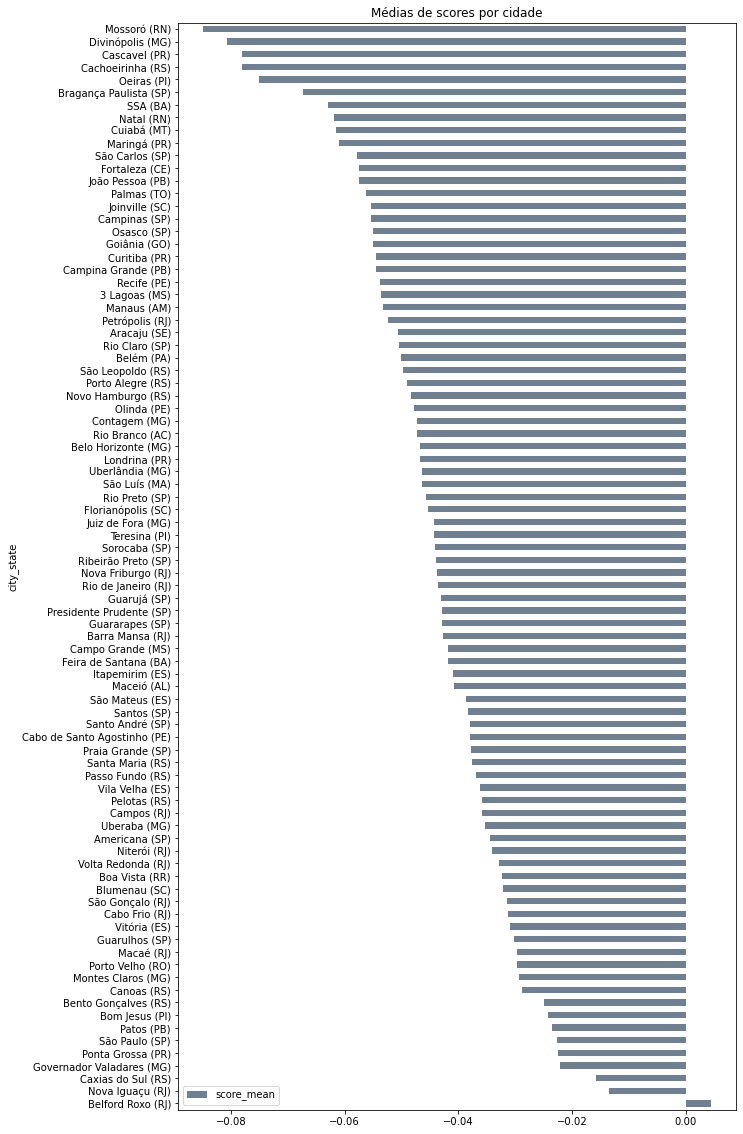

In [39]:
df_cities.sort_values(by=['score_mean'], ascending=False).plot(kind='barh', x='city_state', y='score_mean', figsize=(10, 20), color=back_color_dados_default, title='Médias de scores por cidade')

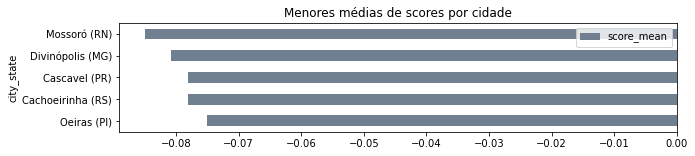

In [40]:
df_neg = df_cities.sort_values(by=['score_mean'], ascending=True)
df_neg[:5].sort_values(by=['score_mean'], ascending=False).plot(kind='barh', x='city_state', y='score_mean', figsize=(10, 2), color=back_color_dados_default, title='Menores médias de scores por cidade')

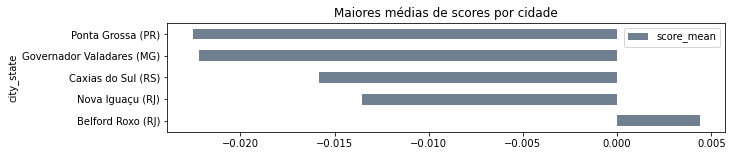

In [41]:
df_pos = df_cities.sort_values(by=['score_mean'], ascending=False)
df_pos[:5].sort_values(by=['score_mean'], ascending=False).plot(kind='barh', x='city_state', y='score_mean', figsize=(10, 2), color=back_color_dados_default, title='Maiores médias de scores por cidade')

**Ranking de entidades mais citadas**

In [42]:
from collections import Counter

In [43]:
max_bars_words = 10
max_clouds_words = 100

In [44]:
def create_df_from_freq(dicts, max_res):
    tokens_freq = return_tokens_freq(dicts, max_res)
    df_words = pd.DataFrame().from_dict(tokens_freq, orient='index', columns=['total'])
    df_words = df_words.sort_values(by = ['total'], ascending=[False])
    df_words = df_words[:max_res]
    df_words = df_words.sort_values(by = ['total'], ascending=[True])  
    return df_words

In [45]:
def return_tokens_freq(dicts, max_res):
    
    final = Counter({})    
    for tokens_dict in dicts: 
        final = Counter(final) + Counter(tokens_dict)
                
    return dict(final.most_common(max_res))

In [80]:
def generate_words_ranking(dicts1, max_res, bar_color, back_color1, title, x, y):

    df1 = create_df_from_freq(dicts1, max_res)
    fig, (ax1) = plt.subplots(ncols=1)    
    ax1.set_facecolor(back_color1)
    df1.plot(kind='barh', ax=ax1, color=bar_color, title=title, figsize=(x,y))
    plt.show()

In [47]:
def generate_cloud_from_tokens_freq(dicts1, max_res, words_color1, back_color1):
    
    tokens_freq1 = return_tokens_freq(dicts1, max_res)
    wordcloud1 = WordCloud(background_color=back_color1, max_words=100, normalize_plurals=False, color_func=lambda *args, **kwargs: words_color1).generate_from_frequencies(tokens_freq1)
    
    fig, (ax1) = plt.subplots(ncols=1)
    
    ax1.set_facecolor(back_color1)
    
    ax1.imshow(wordcloud1, interpolation='bilinear')    
    ax1.axis("off")

In [48]:
def generate_clouds_from_tokens_freq(dicts1, dicts2, max_res, words_color1, words_color2, back_color1, back_color2):
    
    tokens_freq1 = return_tokens_freq(dicts1, max_res)
    wordcloud1 = WordCloud(background_color=back_color1, max_words=100, normalize_plurals=False, color_func=lambda *args, **kwargs: words_color1).generate_from_frequencies(tokens_freq1)

    tokens_freq2 = return_tokens_freq(dicts2, max_res)
    wordcloud2 = WordCloud(background_color=back_color2, max_words=100, normalize_plurals=False, color_func=lambda *args, **kwargs: words_color2).generate_from_frequencies(tokens_freq2)
    
    fig, (ax1, ax2) = plt.subplots(ncols=2)
    
    ax1.set_facecolor(back_color1)
    ax2.set_facecolor(back_color2)
    
    ax1.imshow(wordcloud1, interpolation='bilinear')    
    ax1.axis("off")
    
    ax2.imshow(wordcloud2, interpolation='bilinear')    
    ax2.axis("off")

In [49]:
tokens_list_dados_neg = list(df_cities['tokens_neg'])
tokens_list_dados_pos = list(df_cities['tokens_pos']) 
tokens_list_total = tokens_list_dados_neg + tokens_list_dados_pos

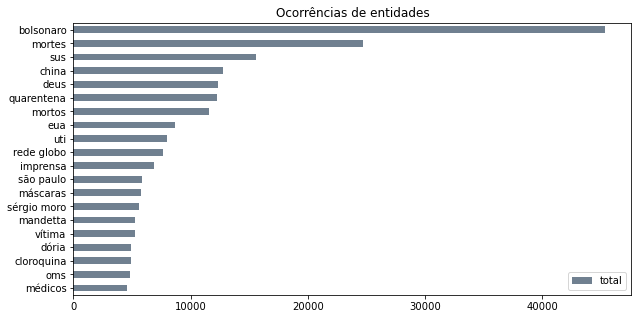

In [83]:
generate_words_ranking(tokens_list_total, 20, back_color_dados_default, 'white', 'Ocorrências de entidades', 10, 5)

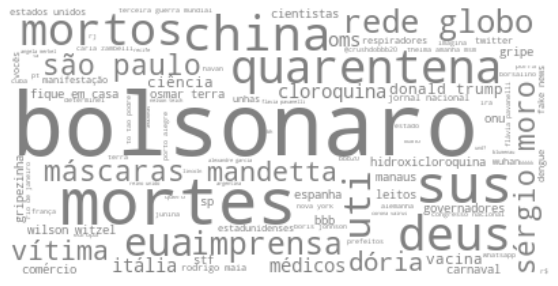

In [67]:
generate_cloud_from_tokens_freq(tokens_list_total, max_clouds_words, 'grey', 'white')

**Médias de sentimentos por período**

In [142]:
def generate_cities_means_bars(df, title, back_color):
    
    bar_width = 0.25

    means_1 = list(df['score_mean_1'])
    means_2 = list(df['score_mean_2'])
    means_3 = list(df['score_mean_3'])

    x1 =  np.arange(len(means_1))
    x2 = [x + bar_width for x in x1]
    x3 = [x + bar_width for x in x2]

    # Plota as barras
    plt.bar(x1, means_1, width=bar_width, label = 'Antes do 1º caso', color = 'lightgrey')
    plt.bar(x2, means_2, width=bar_width, label = 'Após o 1º caso', color = 'gray')
    plt.bar(x3, means_3, width=bar_width, label = 'Após a 1ª morte', color = 'dimgrey')

    # coloca o nome das cidades como label do eixo x
    cities = list(df['city_state'])
    plt.xticks([x + bar_width for x in range(len(means_1))], cities)  
    
    ax = plt.axes()
    ax.set_facecolor(back_color)

    # inseri uma legenda no gráfico
    plt.legend()

    plt.title(title)
    plt.xticks(x1, rotation=90)
    plt.xticks(x2, rotation=90)
    plt.xticks(x3, rotation=90)
    plt.show()

In [53]:
back_color_cidades_neg = 'lavenderblush'
back_color_cidades_pos = 'aliceblue'

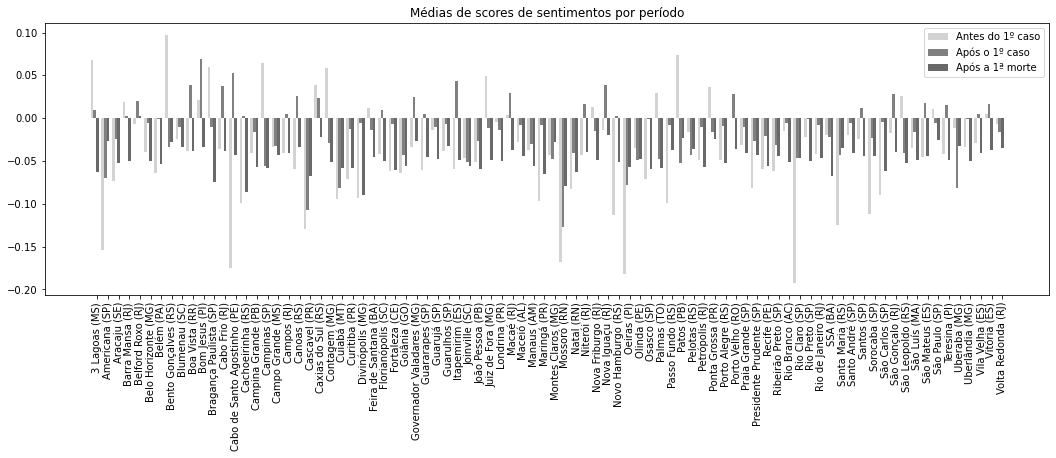

In [143]:
generate_cities_means_bars(df_cities, 'Médias de scores de sentimentos por período', back_color_default)

In [179]:
def generate_cities_means_bars_period(df, column, title, label, back_color, color):
    
    bar_width = 0.5

    means_1 = list(df[column])

    x1 =  np.arange(len(means_1))
    #x2 = [x + bar_width for x in x1]
    #x3 = [x + bar_width for x in x2]

    # Plota as barras
    plt.bar(x1, means_1, width=bar_width, label = label, color = color)

    # coloca o nome das cidades como label do eixo x
    cities = list(df['city_state'])
    plt.xticks([x + bar_width for x in range(len(means_1))], cities)  
    
    ax = plt.axes()
    ax.set_facecolor(back_color)

    # inseri uma legenda no gráfico
    plt.legend()

    plt.title(title)
    plt.xticks(x1, rotation=90)
    #plt.xticks(x2, rotation=90)
    #plt.xticks(x3, rotation=90)
    plt.show()

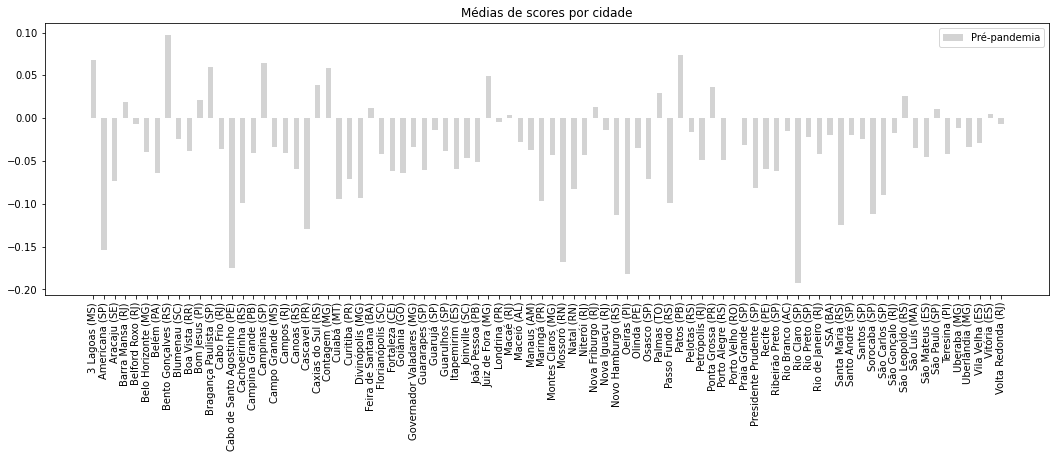

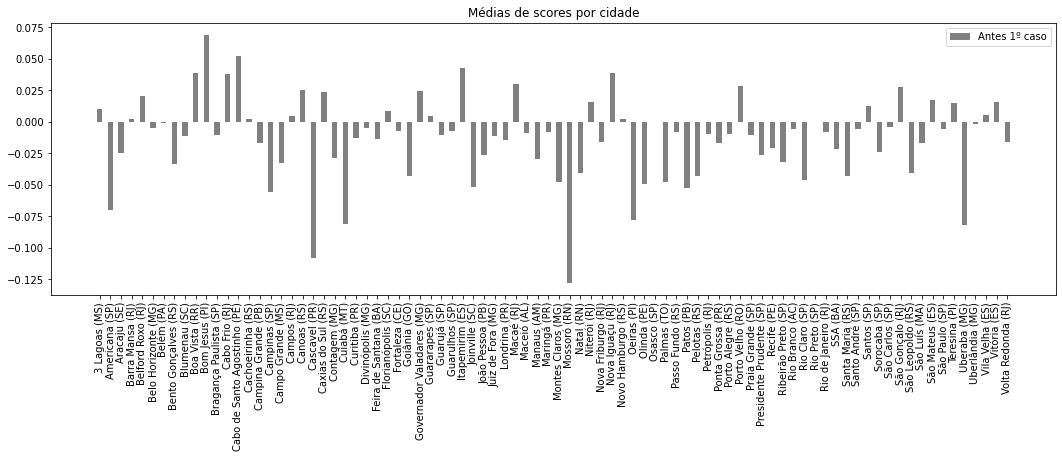

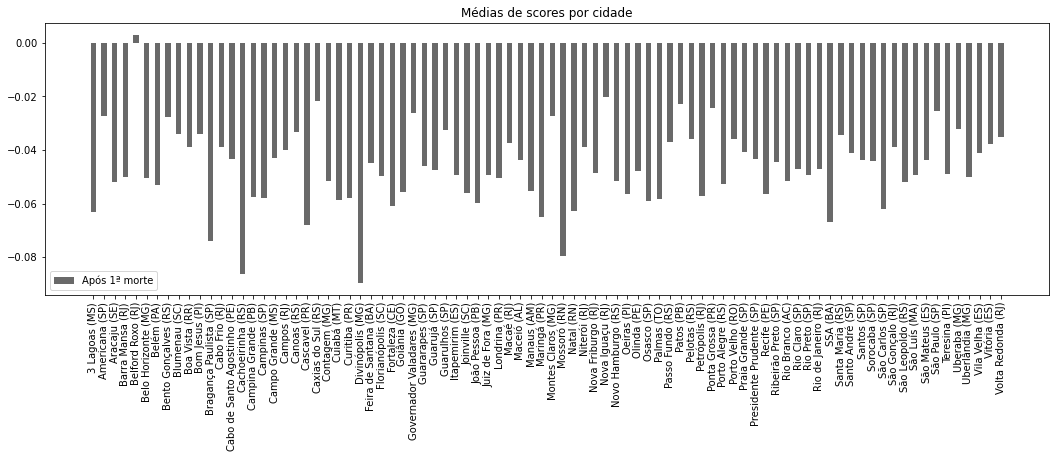

In [180]:
generate_cities_means_bars_period(df_cities, 'score_mean_1', 'Médias de scores por cidade', 'Pré-pandemia', back_color_default, 'lightgrey')
generate_cities_means_bars_period(df_cities, 'score_mean_2', 'Médias de scores por cidade', 'Antes 1º caso', back_color_default, 'gray')
generate_cities_means_bars_period(df_cities, 'score_mean_3', 'Médias de scores por cidade','Após 1ª morte', back_color_default, 'dimgrey')

**Análise da influências negativas e positivas de entidades presentes nos *tweets***

In [55]:
def generate_bar_from_tokens_freq(dicts, max_res, color, x, y, title):
    
    tokens_freq = return_tokens_freq(dicts, max_res)
    df_words = pd.DataFrame().from_dict(tokens_freq, orient='index', columns=['total'])
    df_words = df_words.sort_values(by = ['total'], ascending=[False])
    df_words = df_words[:max_res]
    df_words.sort_values(by = ['total'], ascending=[True]).plot(kind='barh', figsize=(x, y), color=color, title=title)

In [56]:
def generate_cities_bars(dicts1, dicts2, max_res, bar_color1, bar_color2, back_color1, back_color2):

    df1 = create_df_from_freq(dicts1, max_res)   
    df2 = create_df_from_freq(dicts2, max_res)

    fig, (ax1, ax2) = plt.subplots(ncols=2)
    
    ax1.set_facecolor(back_color1)
    ax2.set_facecolor(back_color2)

    df1.plot(kind='barh', ax=ax1, color=bar_color1, title='Entidades que influenciaram negativamente')
    df2.plot(kind='barh', ax=ax2, color=bar_color2, title='Entidades que influenciaram positivamente')

    plt.show()

In [172]:
def generate_periods_cities_bars(dicts1, dicts2, dicts3, dicts4, dicts5, dicts6, max_res, bar_color1, bar_color2, back_color1, back_color2):

    df1 = create_df_from_freq(dicts1, max_res)
    df2 = create_df_from_freq(dicts2, max_res)
    df3 = create_df_from_freq(dicts3, max_res) 
    
    df4 = create_df_from_freq(dicts4, max_res)
    df5 = create_df_from_freq(dicts5, max_res)
    df6 = create_df_from_freq(dicts6, max_res)

    fig, (ax1, ax2, ax3) = plt.subplots(ncols=3)
    fig, (ax4, ax5, ax6) = plt.subplots(ncols=3)
    
    ax1.set_facecolor(back_color1)
    ax2.set_facecolor(back_color1)
    ax3.set_facecolor(back_color1)
    
    ax4.set_facecolor(back_color2)
    ax5.set_facecolor(back_color2)
    ax6.set_facecolor(back_color2)

    df1.plot(kind='barh', ax=ax1, color=bar_color1, title='Antes do 1º caso')
    df2.plot(kind='barh', ax=ax2, color=bar_color1, title='Depois do 1º caso')
    df3.plot(kind='barh', ax=ax3, color=bar_color1, title='Após 1ª morte')
    
    df4.plot(kind='barh', ax=ax4, color=bar_color2, title='Antes do 1º caso')
    df5.plot(kind='barh', ax=ax5, color=bar_color2, title='Depois do 1º caso')
    df6.plot(kind='barh', ax=ax6, color=bar_color2, title='Após 1ª morte')

    plt.show()

In [168]:
def generate_periods_cities_bars_v(dicts1, dicts2, dicts3, dicts4, dicts5, dicts6, max_res, bar_color1, bar_color2, back_color1, back_color2, x, y):

    df1 = create_df_from_freq(dicts1, max_res)
    df2 = create_df_from_freq(dicts2, max_res)
    df3 = create_df_from_freq(dicts3, max_res) 
    
    df4 = create_df_from_freq(dicts4, max_res)
    df5 = create_df_from_freq(dicts5, max_res)
    df6 = create_df_from_freq(dicts6, max_res)

    fig, [[ax1, ax4], [ax2, ax5], [ax3, ax6]] = plt.subplots(nrows=3, ncols=2)

    ax1.set_facecolor(back_color1)
    ax2.set_facecolor(back_color1)
    ax3.set_facecolor(back_color1)
    
    ax4.set_facecolor(back_color2)
    ax5.set_facecolor(back_color2)
    ax6.set_facecolor(back_color2)

    df1.plot(kind='barh', figsize=(x, y), ax=ax1, color=bar_color1, title='Pré-pandemia')
    df2.plot(kind='barh', figsize=(x, y), ax=ax2, color=bar_color1, title='Após 1º caso')
    df3.plot(kind='barh', figsize=(x, y), ax=ax3, color=bar_color1, title='Após 1ª morte')
    
    df4.plot(kind='barh', figsize=(x, y), ax=ax4, color=bar_color2, title='Pré-pandemia')
    df5.plot(kind='barh', figsize=(x, y), ax=ax5, color=bar_color2, title='Após 1º caso')
    df6.plot(kind='barh', figsize=(x, y), ax=ax6, color=bar_color2, title='Após 1ª morte')
    
    plt.show()

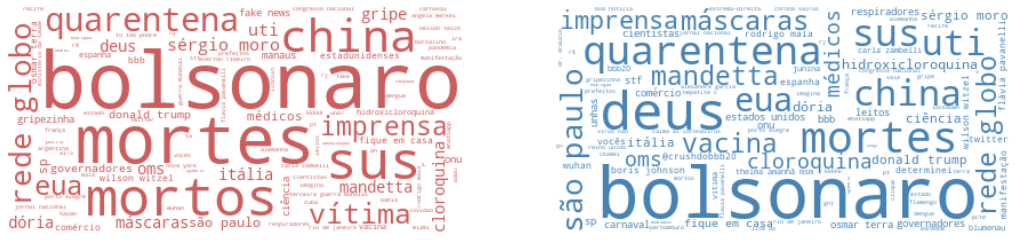

In [69]:
generate_clouds_from_tokens_freq(df_cities['tokens_neg'], df_cities['tokens_pos'], max_clouds_words, back_color_dados_neg, back_color_dados_pos, back_color_default, back_color_default)

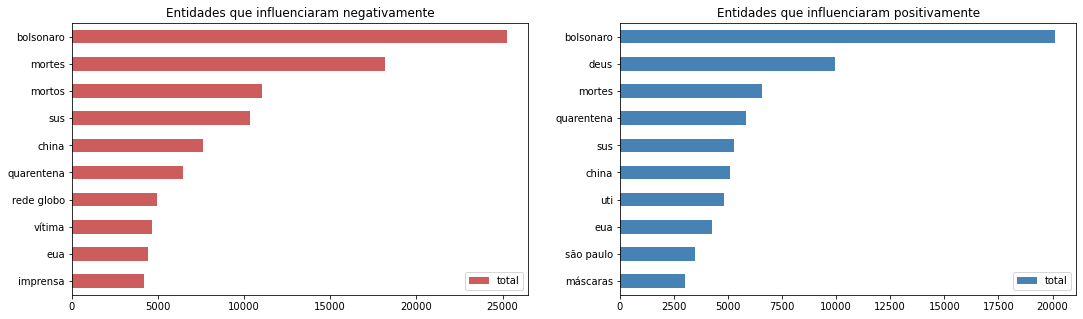

In [70]:
generate_cities_bars(df_cities['tokens_neg'], df_cities['tokens_pos'], max_bars_words, back_color_dados_neg, back_color_dados_pos, back_color_default, back_color_default)

Análise por período

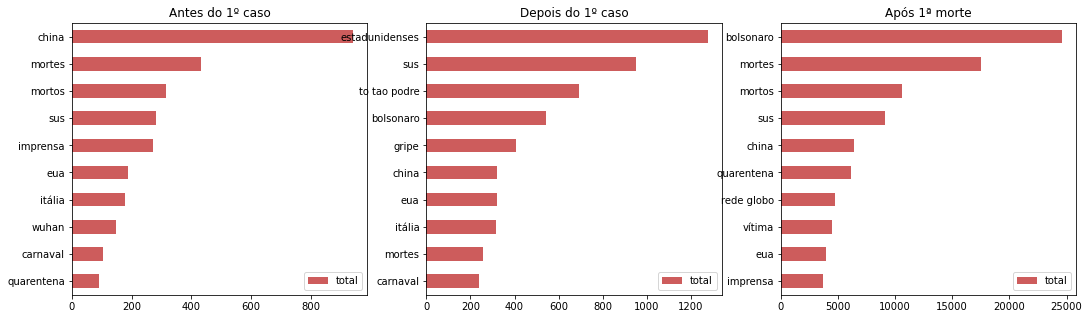

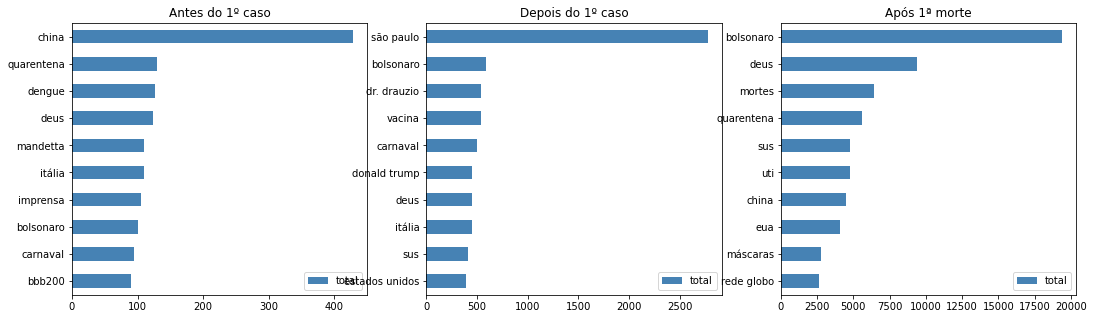

In [173]:
generate_periods_cities_bars(df_cities['tokens_neg_1'], df_cities['tokens_neg_2'], df_cities['tokens_neg_3'], df_cities['tokens_pos_1'], df_cities['tokens_pos_2'], df_cities['tokens_pos_3'], max_bars_words, back_color_dados_neg, back_color_dados_pos, back_color_default, back_color_default)

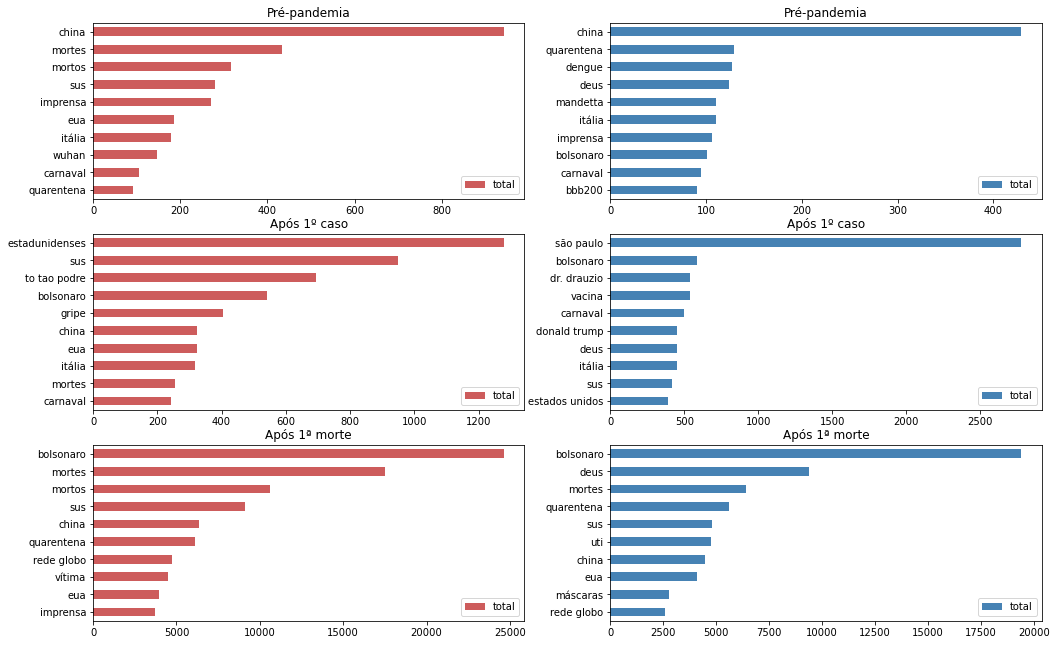

In [169]:
generate_periods_cities_bars_v(df_cities['tokens_neg_1'], df_cities['tokens_neg_2'], df_cities['tokens_neg_3'], df_cities['tokens_pos_1'], df_cities['tokens_pos_2'], df_cities['tokens_pos_3'], max_bars_words, back_color_dados_neg, back_color_dados_pos, back_color_default, back_color_default, 17, 11)

**Média de *scores* de sentimento por dia**

In [61]:
# Função para montar um df de Quantificadores por data a partir do df de Tweets
def building_dates_df(df, date_list, column):

    score_mean_list = []
        
    # Populando quantificadores para cada dia
    for index in date_list:
        
        try:
            # Média de scores do dia
            score_mean = mean(df[column].loc[(df['created_at'].dt.year == index.year) & (df['created_at'].dt.month == index.month) & (df['created_at'].dt.day == index.day)])
            score_mean_list.append(score_mean)
        except:
            score_mean_list.append(0)
    
    # Dicionário utilizado como parâmetro para a montagem
    data={'created_at': pd.Series(date_list), column + '_mean':pd.Series(score_mean_list)}
    
    # Criando df
    df = pd.DataFrame(data)
    
    return df 

In [62]:
def generate_cities_lines(df, df_cities, title, back_color):
    
    df_cities = df_cities.reset_index()
    
    cities = list(df_cities['city'])   
    fig, ax = plt.subplots()
    
    date_list = list(pd.to_datetime(df['created_at']).dt.date.unique())
    
    score_total = 0
      
    for index, row in df_cities.iterrows():
        
        df_scores = df.loc[df['city'] == row['city']]
        df_dates = building_dates_df(df_scores, date_list, 'score')   
        
        score_total = score_total + df_dates.score_mean
        
        x = date_list
        y = df_dates.score_mean

        ax.plot(x, y, linestyle='solid', linewidth=2, label=row['city'], color='grey')
       
    plt.axvline(first_case, color='red')
    plt.axvline(first_death, color='black')
                
    ax.grid()
    ax.margins(0)
    ax.set_facecolor(back_color)

    plt.rcParams['figure.figsize'] = (18,5)
    plt.xticks(x, rotation=90)
    plt.xlabel('Datas',fontsize=15)
    plt.ylabel('Médias',fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')
    plt.show()

In [63]:
def generate_cities_means_lines(df, df_cities, title, back_color):
    
    df_cities = df_cities.reset_index()
    
    cities = list(df_cities['city'])   
    fig, ax = plt.subplots()
    
    date_list = list(pd.to_datetime(df['created_at']).dt.date.unique())
    
    score_total = 0
      
    for index, row in df_cities.iterrows():
        
        df_scores = df.loc[df['city'] == row['city']]
        df_dates = building_dates_df(df_scores, date_list, 'score')   
        
        score_total = score_total + df_dates.score_mean
       
    plt.axvline(first_case, color='red')
    plt.axvline(first_death, color='black')
        
    x = date_list
    y = score_total / len(cities)
    
    ax.plot(x, y, linestyle='solid', linewidth=2, label=row['city'], color='grey')
        
    ax.grid()
    ax.margins(0)
    ax.set_facecolor(back_color)

    plt.rcParams['figure.figsize'] = (18,5)
    plt.xticks(x, rotation=90)
    plt.xlabel('Datas',fontsize=15)
    plt.ylabel('Médias',fontsize=15)
    plt.title(title)
    plt.grid(True, linestyle='--')
    plt.show()

Os gráficos abaixo apresentaram as médias diárias dos *scores*. O primeiro gráfico plota as médias de todas as cidades e o segundo gráfico consolida as médias de todas as cidades analisadas.

As linhas verticais dividem os períodos analisados da seguinte forma:

- Linha vermelha: Primeiro caso de Covid-19 no Brasil;
- Linha preta: Primeira morte por Covid-19 no Brasil.

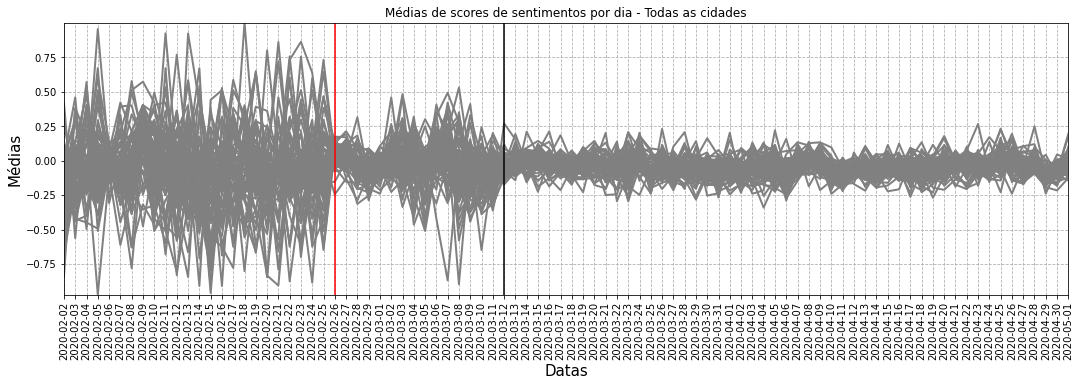

In [72]:
generate_cities_lines(df, df_cities, 'Médias de scores de sentimentos por dia - Todas as cidades', back_color_default)

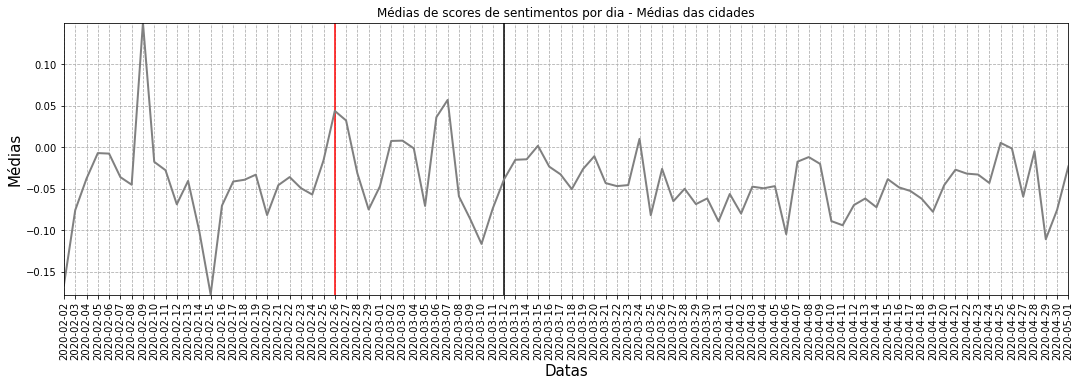

In [73]:
generate_cities_means_lines(df, df_cities, 'Médias de scores de sentimentos por dia - Médias das cidades', back_color_default)

***
**Resumo**

Este *notebook* apresentou análises com base nos resultados de sentimentos obtidos nos *tweets* selecionados na etapa anterior deste trabalho.

As análises foram realizadas com cidades que continham um número mínimo de *tweets* para cada período analisado: **antes do primeiro caso de Covid-19**, **após o primeiro caso de Covid-19**, **após a primeira morte por Covid-19 no Brasil**, objetivando observar o **comportamento dos usuários do Twitter** durante os períodos analisados e a que eles **poderiam estar relacionados**.

***
**Fontes**

(1) VADER: A Parsimonious Rule-based Model for Sentiment Analysis of Social Media Text

(2) Agência Brasil - Primeiro caso de covid-19 no Brasil completa um ano - https://agenciabrasil.ebc.com.br/saude/noticia/2021-02/primeiro-caso-de-covid-19-no-brasil-completa-um-ano

(3) Spacy - https://spacy.io/

(4) Demoji - https://pypi.org/project/demoji/

(5) Spacy - Linguistic Features - https://spacy.io/usage/linguistic-features

(6) Spacy - https://spacy.io/models/pt

(7) Agência Brasil - Primeira morte por covid-19 no Brasil aconteceu em 12 de março - https://agenciabrasil.ebc.com.br/saude/noticia/2020-06/primeira-morte-por-covid-19-no-brasil-aconteceu-em-12-de-marco